# 1. Data preparation and exploration
## 1.1 Creating Spark Session
### 1. Create a SparkConf object for using as many local cores as possible

In [1]:
pip install sklearn

Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf

In [3]:
# using as many local cores as possible
master = "local[*]"
app_name = "Detecting hacking activities"
# Set the maximum size of the partition to a smaller value so that small files will also be divided
spark_conf = SparkConf().setMaster(master).setAppName(app_name).set("spark.files.maxPartitionBytes", "13421772")

### 2. Then create a SparkSession using the SparkConf object.

In [4]:
spark = SparkSession.builder.config(conf = spark_conf).getOrCreate()
sc = spark.sparkContext

## 1.2 Loading the data

### 1. Load each activity data into a Spark dataframe and cache the data

In [5]:
# In order to speed up the loading process, specify the schema before reading the data into dataframes
memory_schema = StructType([
    StructField("ts", IntegerType()),
    StructField("PID", IntegerType()),
    StructField("MINFLT", IntegerType()),
    StructField("MAJFLT", IntegerType()),
    StructField("VSTEXT", IntegerType()),
    StructField("VSIZE", DoubleType()),
    StructField("RSIZE", IntegerType()),
    StructField("VGROW", IntegerType()),
    StructField("RGROW", IntegerType()),
    StructField("MEM", DoubleType()),
    StructField("CMD", StringType()),
    StructField("attack", IntegerType()),
    StructField("type", StringType()),
])

process_schema = StructType([
    StructField("ts", IntegerType()),
    StructField("PID", IntegerType()),
    StructField("TRUN", IntegerType()),
    StructField("TSLPI", IntegerType()),
    StructField("TSLPU", IntegerType()),
    StructField("POLI", StringType()),
    StructField("NICE", IntegerType()),
    StructField("PRI", IntegerType()),
    StructField("PTPR", IntegerType()),
    StructField("CPUNR", IntegerType()),
    StructField("Status", StringType()),
    StructField("EXC", IntegerType()),
    StructField("State", StringType()),
    StructField("CPU", DoubleType()),
    StructField("CMD", StringType()),
    StructField("attack", IntegerType()),
    StructField("type", StringType()),
])


In [6]:
memory_df = spark.read.csv("linux_memory*", header = True, schema = memory_schema).cache()
process_df = spark.read.csv("linux_process*", header = True, schema = process_schema).cache()

In [7]:
# print out the row count of each dataframe
print(memory_df.count())
print(process_df.count())

2000000
1927968


### 2. For each column in each dataframe above, 
○ Check the null data (if any) and print out the corresponding count in each column

In [8]:
null_count = []
for col in memory_df.columns:
#     If the value is empty, it is recorded in count，modified column name as it's original name
    null_count.append(F.count(F.when(F.isnull(col),col)).alias(col))
#     The Column parameter type of the select method is overloaded to support SQL's select syntax
memory_df.select(null_count).show()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|  9737|448868| 27907|    0|83545|50912|10294|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



In [9]:
null_count = []
for col in process_df.columns:
    null_count.append(F.count(F.when(F.isnull(col),col)).alias(col))
process_df.select(null_count).show()

+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
| ts|PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|PTPR|CPUNR|Status|EXC|State|CPU|CMD|attack|type|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
|  0|  0|   0|    0|    0|   0|   0|  0|   0|    0|     0|  0|    0|  0|  0|     0|   0|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+



It can be seen that the MINFLT|MAJFLT|VSTEXT|RSIZE|VGROW|RGROW column in memory df contains null values, which is the error when casting the type
some data may not fully comply with the schema, we need to import them as StringType and convert the type after further processing

In [10]:
memory_schema = StructType([
    StructField("ts", IntegerType()),
    StructField("PID", IntegerType()),
    StructField("MINFLT", StringType()),
    StructField("MAJFLT", StringType()),
    StructField("VSTEXT", StringType()),
    StructField("VSIZE", DoubleType()),
    StructField("RSIZE", StringType()),
    StructField("VGROW", StringType()),
    StructField("RGROW", StringType()),
    StructField("MEM", DoubleType()),
    StructField("CMD", StringType()),
    StructField("attack", IntegerType()),
    StructField("type", StringType()),
])
memory_df = spark.read.csv("linux_memory*", header = True, schema = memory_schema).cache()

In [11]:
test_df = memory_df.select("RSIZE", F.col("RSIZE").cast(IntegerType()).alias("IntegerType"))
test_df.filter(F.col("IntegerType").isNull()).show(10)

+------+-----------+
| RSIZE|IntegerType|
+------+-----------+
|224.2M|       null|
|224.2M|       null|
|224.2M|       null|
|224.2M|       null|
|224.2M|       null|
|224.2M|       null|
|    0K|       null|
|    0K|       null|
|    0K|       null|
|    0K|       null|
+------+-----------+
only showing top 10 rows



In [12]:
test_df = memory_df.select("VGROW", F.col("VGROW").cast(IntegerType()).alias("IntegerType"))
test_df.filter(F.col("IntegerType").isNull()).tail(5)

[Row(VGROW='380 2', IntegerType=None),
 Row(VGROW='5552 1', IntegerType=None),
 Row(VGROW='0 7', IntegerType=None),
 Row(VGROW='0 1', IntegerType=None),
 Row(VGROW='0 2', IntegerType=None)]

After inspection, it is found that the data contains k and m representing 1000 and 1000000,  
some data contains spaces, we need to convert them

In [13]:
def func(num):
#     Remove spaces, process k and m separately
    num = num.replace(' ','')
    if num.find('M') != -1:
        num = int(float(num[:-1]) * 1000000)
    elif num.find('K') != -1:
        num = int(float(num[:-1]) * 1000)
    return num
# finally convert to string
convert = udf(func, StringType())

In [14]:
memory_df = memory_df.withColumn("MINFLT", convert("MINFLT").cast(IntegerType()))
memory_df = memory_df.withColumn("MAJFLT", convert("MAJFLT").cast(IntegerType()))
memory_df = memory_df.withColumn("VSTEXT", convert("VSTEXT").cast(IntegerType()))
memory_df = memory_df.withColumn("RSIZE", convert("RSIZE").cast(DoubleType()))
memory_df = memory_df.withColumn("VGROW", convert("VGROW").cast(DoubleType()))
memory_df = memory_df.withColumn("RGROW", convert("RGROW").cast(DoubleType()))

In [15]:
null_count = []
for col in memory_df.columns:
    null_count.append(F.count(F.when(F.isnull(col),col)).alias(col))
memory_df.select(null_count).show()
# Now processing is complete

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



## 1.3 Exploring the data
### 1. Show the count of attack and non-attack in each activity based on the column “attack”
○ Do you see any class imbalance? Examine and describe what you observe

In [16]:
# The number of non-attacks is several times that of attacks
memory_df.groupby("attack").count().show()

+------+-------+
|attack|  count|
+------+-------+
|     1| 205623|
|     0|1794377|
+------+-------+



In [17]:
process_df.groupby("attack").count().show()

+------+-------+
|attack|  count|
+------+-------+
|     1| 291364|
|     0|1636604|
+------+-------+



### then show the count of each kind of attack in process activity based on the column “type”.  

In [18]:
process_df.filter(F.col("attack") == 1).groupby("type").count().show()

+---------+-----+
|     type|count|
+---------+-----+
|      xss|17759|
| password|51409|
| scanning|38449|
|     ddos|71603|
|     mitm|  112|
|injection|41311|
|      dos|70721|
+---------+-----+



In [19]:
memory_df.filter(F.col("attack") == 1).groupby("type").count().show()

+---------+-----+
|     type|count|
+---------+-----+
| password|26016|
|     ddos|45689|
|     mitm|  112|
|injection|58523|
|      dos|75283|
+---------+-----+



### 2. For each numeric feature in each activity, show the basic statistics (including count, mean, stddev, min, max)

In [20]:
# Get the type of each column
process_numeric = [col.name for col in process_df.schema 
                   if isinstance(col.dataType, IntegerType) or isinstance(col.dataType, DoubleType)]
memory_numeric = [col.name for col in memory_df.schema 
                  if isinstance(col.dataType, IntegerType) or isinstance(col.dataType, DoubleType)]

In [21]:
# Use summary to show details
process_df.select(process_numeric).summary().show()

+-------+--------------------+-----------------+------------------+-----------------+--------------------+-----------------+------------------+-------+------------------+--------------------+--------------------+------------------+
|summary|                  ts|              PID|              TRUN|            TSLPI|               TSLPU|             NICE|               PRI|   PTPR|             CPUNR|                 EXC|                 CPU|            attack|
+-------+--------------------+-----------------+------------------+-----------------+--------------------+-----------------+------------------+-------+------------------+--------------------+--------------------+------------------+
|  count|             1927968|          1927968|           1927968|          1927968|             1927968|          1927968|           1927968|1927968|           1927968|             1927968|             1927968|           1927968|
|   mean|1.5563198311840394E9|5068.709770597852|0.0632287465352122|3.508

In [22]:
memory_df.select(memory_numeric).summary().show()

+-------+------------------+-----------------+------------------+--------------------+-----------------+-----------------+------------------+-----------------+------------------+--------------------+-------------------+
|summary|                ts|              PID|            MINFLT|              MAJFLT|           VSTEXT|            VSIZE|             RSIZE|            VGROW|             RGROW|                 MEM|             attack|
+-------+------------------+-----------------+------------------+--------------------+-----------------+-----------------+------------------+-----------------+------------------+--------------------+-------------------+
|  count|           2000000|          2000000|           2000000|             2000000|          2000000|          2000000|           2000000|          2000000|           2000000|             2000000|            2000000|
|   mean|1.55624581707609E9|      4999.360446|        983.344344|       987846.478731|    46453.2681675|4496.41996644593

### for each non-numeric feature in each activity, display the top-10 values and the corresponding counts.

In [23]:
from pyspark.sql.functions import desc
process_non_numeric = [col.name for col in process_df.schema if col.name not in process_numeric]
for col in process_non_numeric:
    process_df.select(col).groupby(col).count().orderBy(desc('count')).show(10)

+----+-------+
|POLI|  count|
+----+-------+
|norm|1861558|
|   0|  53216|
|   -|  13194|
+----+-------+

+------+-------+
|Status|  count|
+------+-------+
|     -|1416322|
|     0| 438984|
|    NE|  48602|
|     N|  23313|
|    NS|    743|
|     C|      3|
|    NC|      1|
+------+-------+

+-----+-------+
|State|  count|
+-----+-------+
|    S|1676350|
|    I|  98986|
|    R|  84753|
|    E|  66410|
|    Z|   1118|
|    D|    344|
|    T|      7|
+-----+-------+

+--------------+------+
|           CMD| count|
+--------------+------+
|          atop|441180|
|       apache2|313143|
|      vmtoolsd|112029|
|          Xorg| 66813|
|      nautilus| 63449|
|gnome-terminal| 47628|
|        compiz| 44386|
|    irqbalance| 44324|
|      ostinato| 42979|
|         drone| 41390|
+--------------+------+
only showing top 10 rows

+---------+-------+
|     type|  count|
+---------+-------+
|   normal|1636604|
|     ddos|  71603|
|      dos|  70721|
| password|  51409|
|injection|  41311|
| scann

In [24]:
memory_non_numeric = [col.name for col in memory_df.schema if col.name not in memory_numeric]
for col in memory_non_numeric:
    memory_df.select(col).groupby(col).count().orderBy(desc('count')).show(10)

+----------+------+
|       CMD| count|
+----------+------+
|      atop|325985|
|   apache2| 89761|
| jfsCommit| 81714|
|  vmtoolsd| 77871|
|      Xorg| 49981|
|  nautilus| 48356|
|irqbalance| 44387|
|    compiz| 44356|
|  ostinato| 43024|
|     drone| 41392|
+----------+------+
only showing top 10 rows

+---------+-------+
|     type|  count|
+---------+-------+
|   normal|1794377|
|      dos|  75283|
|injection|  58523|
|     ddos|  45689|
| password|  26016|
|     mitm|    112|
+---------+-------+



### 3. For each activity, present two plots worthy of presenting to the StopHacking company, describe your plots and discuss the findings from the plots

In [25]:
import matplotlib.pylab as plt
import numpy as np
# using sampling before plotting
process_sampled = process_df.sample(fraction = 0.1).toPandas()

### Process activity
The histogram divides the range of the entire PRI observation data into a series of intervals. The value in each interval is called the frequency (vertical axis). We can see that the attack type PRI is more concentrated in the range of 100-120 than the common type PRI. , There is almost no data on the highest priority

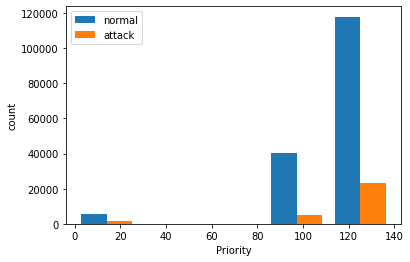

In [26]:
from matplotlib.patches import Rectangle
normal = process_sampled[process_sampled.attack == 0]['PRI']
attack = process_sampled[process_sampled.attack == 1]['PRI']
plt.hist([normal, attack],5)
plt.xlabel('Priority')
plt.ylabel('count')
labels= ["normal","attack"]
plt.legend(labels = labels)
plt.show()

Using the scatter chart to observe the data distribution, we can see that the common type of EXC is more concentrated than the attack type of EXC in the range of 0-20, and there are data more than 120 

<ipython-input-27-4a595588c042>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot()
<ipython-input-27-4a595588c042>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(["0","normal","attack"])


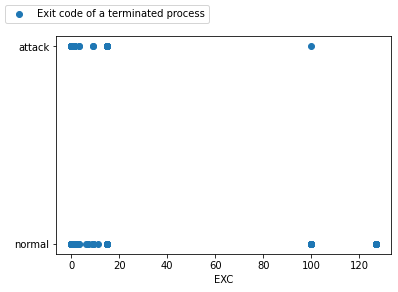

In [27]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
plt.scatter(process_sampled['EXC'], process_sampled['attack'],label = 'Exit code of a terminated process')
# Add a subgraph and set the interval of the y-axis value to 1
ax = plt.subplot()
ax.yaxis.set_major_locator(MultipleLocator(1))
plt.gca().set_yticklabels(["0","normal","attack"])
plt.figlegend(loc="upper left")
plt.xlabel("EXC")
plt.show()

In [28]:
memory_sampled = memory_df.sample(fraction = 0.01).toPandas()

### Memory activity
Using boxplot to observe the data distribution, we can see that the attack type VSTEXT has a higher average value than the ordinary type VSTEXT, and there are more data at the highest point, which shows that a lot of virtual memory size used by the shared text.

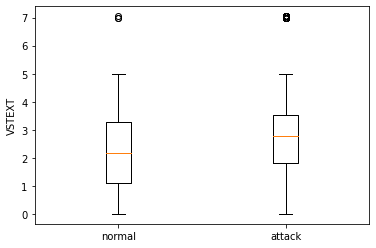

In [29]:
normal = memory_sampled[memory_sampled.attack == 0]['VSTEXT']
attack = memory_sampled[memory_sampled.attack == 1]['VSTEXT']
plt.boxplot([np.log10(normal + 1), np.log10(attack + 1)],labels = ['normal','attack'])
plt.ylabel('VSTEXT')
plt.show()

Use the scatter chart to observe the difference between VGROW and RGROW in the normal type and the attack type at the same time. It can be seen that RGROW becomes clustered at a larger value in the attack type, but VGROW does not change much(still evenly distributed), indicating that RGROW and attack is more relevant

/home/student/.local/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/student/.local/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


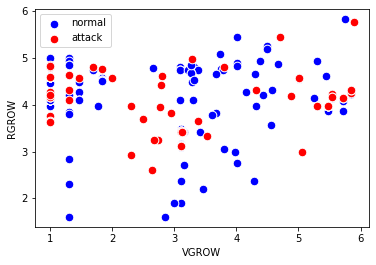

In [30]:
x = memory_sampled[memory_sampled.attack == 0]['VGROW']
y = memory_sampled[memory_sampled.attack == 0]['RGROW']
plt.scatter(np.log10(x) + 1, np.log10(y) + 1, s=300, label = 'normal', c = 'blue', marker='.', edgecolors= 'white')
x = memory_sampled[memory_sampled.attack == 1]['VGROW']
y = memory_sampled[memory_sampled.attack == 1]['RGROW']
plt.scatter(np.log10(x) + 1, np.log10(y) + 1, s=300, label = 'attack', c = 'red', marker='.', edgecolors= 'white')

# 显示图例
plt.legend()
plt.xlabel('VGROW')
plt.ylabel('RGROW')
plt.show()

# 2. Feature extraction and ML training
## 2.1 Preparing the training data and testing data 
### 1. Randomly split the dataset into 80% training data and 20% testing data for each use case
### 2. With the class imbalance observed from 1.3.1, for the binary classification use case 1 & 2, prepare rebalanced training data, with attack events and non-attack events being 1:2 ratio, while using 20% attack events data from the training data from 2.1.1. Cache the rebalanced training data, and display the count of each event's data

In [192]:
# Randomly split the dataset into 80% training data and 20%
train_process, test_process = process_df.randomSplit([0.8, 0.2])
#  using 20% attack events data from the training data
train_process_attack = train_process.filter(F.col('attack') == 1).sample(0.2)
train_process_normal = train_process.filter(F.col('attack') == 0)
# attack events and non-attack events being 1:2 ratio
train_process_normal = train_process_normal.sample(train_process_attack.count() * 2 / train_process_normal.count())
train_process = train_process_normal.union(train_process_attack).cache()

In [193]:
train_memory, test_memory = memory_df.randomSplit([0.8, 0.2])
train_memory_attack = train_memory.filter(F.col('attack') == 1).sample(0.2)
train_memory_normal = train_memory.filter(F.col('attack') == 0)
train_memory_normal = train_memory_normal.sample(train_memory_attack.count() * 2 / train_memory_normal.count())
train_memory = train_memory_normal.union(train_memory_attack).cache()

## 2.2 Preparing features, labels and models
### 1. Based on data exploration from 1.3.3, which features would you select? Discuss the reason for selecting them and how you plan to further transform them

### Process activity

According to 1.3.3, PRI and EXC are used, they can distinguish whether they are attack or not, NICE is another priority so it is used. There are also all the String type feature, not taken into account when doing the diagram, so also selected. I don't use CMD, there are too many kinds of CMD, if we use it, it may make the content in the train not in the test. Then I'm not choosing ts and PID, because the time or process number of the attacker is not fixed at all, they are not related. Type can't be chosen either, because only attack type will have a type, which is equivalent to directly determine whether it is an attack or not.

In [194]:
cols = ['POLI','NICE','PRI','Status','EXC','State','attack']

In [195]:
process_train_df = train_process.select(cols)
test_process = test_process.select(cols)

In [196]:
# First convert POLI according to our custom Transformer dict
key = ["norm", "btch", "idle", "fifo", "rr", "0", "-"]
value = ['0', '1', '2', '3', '4', '5', '6']
dic = {k:v for (k,v) in zip(key,value)}
process_train_df = process_train_df.na.replace(dic,1,"POLI")
process_train_df = process_train_df.withColumn("POLI", F.col("POLI").cast(IntegerType()))
test_process = test_process.na.replace(dic,1,"POLI")
test_process = test_process.withColumn("POLI", F.col("POLI").cast(IntegerType()))

/home/student/.local/lib/python3.8/site-packages/pyspark/sql/dataframe.py:1894: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


In [197]:
process_train_df.printSchema()

root
 |-- POLI: integer (nullable = true)
 |-- NICE: integer (nullable = true)
 |-- PRI: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- attack: integer (nullable = true)



In [198]:
# Select number type features except attack.
p_numeric_cols = [col.name for col in process_train_df.schema.fields if col.name != 'attack'
               and (isinstance(col.dataType, IntegerType) or isinstance(col.dataType, DoubleType))]

In [199]:
p_non_numeric_cols = [col for col in process_train_df.columns if col not in p_numeric_cols + ['attack']]

### Memory activity
According to 1.3.3, choose RGROW and VSTEXT, they can distinguish whether it is an attack. Since there are network attacks that affect the server's memory and other processing, the memory-related features are selected, and the other features are not selected for the same reasons as before.

In [200]:
cols = ['MINFLT','MAJFLT','VSTEXT', 'VSIZE', 'RSIZE', 'RGROW','attack']

In [201]:
memory_train_df = train_memory.select(cols)
test_memory = test_memory.select(cols)

In [202]:
m_numeric_cols = [col.name for col in memory_train_df.schema.fields if col.name != 'attack'
               and (isinstance(col.dataType, IntegerType) or isinstance(col.dataType, DoubleType))]

In [203]:
m_non_numeric_cols = [col for col in memory_train_df.columns if col not in m_numeric_cols + ['attack']]

In [204]:
# This time it’s all numeric features
m_non_numeric_cols

[]

### 2. Create Transformers / Estimators for transforming / assembling the features you selected above in 2.2.1
### 3. Prepare Estimators for Decision Tree and Gradient Boosted Tree model for each use case and include them into ML Pipelines for use case 1, 2

In [205]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler

In [206]:
#  Stage 1:String Indexer
inputCols = p_non_numeric_cols
outputCols = [col + '_index' for col in p_non_numeric_cols]
stage_1 = StringIndexer(inputCols = inputCols, outputCols = outputCols).setHandleInvalid("keep") 

# Stage 2: One Hot Encoder
inputCols_OHE = outputCols
outputCols_OHE = [col + '_vec' for col in inputCols]
stage_2 = OneHotEncoder(inputCols = inputCols_OHE, outputCols = outputCols_OHE)

# Stage 3: Vector Assembler
p_DT_inputCols = outputCols_OHE + p_numeric_cols
stage_3 = VectorAssembler(inputCols = p_DT_inputCols, outputCol = 'features')

# Stage 4: ML Algorithm
stage_4 = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'attack')

In [207]:
stage_1.fit(process_train_df).transform(test_process).show()
s1 = stage_1.fit(process_train_df).transform(test_process)
stage_2.fit(s1).transform(s1).show()
s2 = stage_2.fit(s1).transform(s1)
stage_3.transform(s2).show()

+----+----+---+------+---+-----+------+------------+-----------+
|POLI|NICE|PRI|Status|EXC|State|attack|Status_index|State_index|
+----+----+---+------+---+-----+------+------------+-----------+
|   0|   0|120|     N|  0|    S|     0|         3.0|        0.0|
|   0|   0|120|     N|  0|    S|     0|         3.0|        0.0|
|   0|   0|120|     N|  0|    S|     0|         3.0|        0.0|
|   0|   0|120|     N|  0|    S|     0|         3.0|        0.0|
|   0|   0|120|     N|  0|    S|     0|         3.0|        0.0|
|   0|  19|139|     N|  0|    S|     0|         3.0|        0.0|
|   0|   0|120|     N|  0|    S|     0|         3.0|        0.0|
|   0|   0|120|     N|  0|    S|     0|         3.0|        0.0|
|   0|   0|120|     N|  0|    S|     0|         3.0|        0.0|
|   0|  20|100|     N|  0|    R|     0|         3.0|        2.0|
|   0|   0|120|     N|  0|    S|     0|         3.0|        0.0|
|   0|   0|120|     N|  0|    S|     0|         3.0|        0.0|
|   0|   0|120|     N|  0

In [208]:
s3 = stage_3.transform(s2)
s3.select("features", "attack").show(truncate=False)

+-------------------------------------+------+
|features                             |attack|
+-------------------------------------+------+
|(16,[3,5,14],[1.0,1.0,120.0])        |0     |
|(16,[3,5,14],[1.0,1.0,120.0])        |0     |
|(16,[3,5,14],[1.0,1.0,120.0])        |0     |
|(16,[3,5,14],[1.0,1.0,120.0])        |0     |
|(16,[3,5,14],[1.0,1.0,120.0])        |0     |
|(16,[3,5,13,14],[1.0,1.0,19.0,139.0])|0     |
|(16,[3,5,14],[1.0,1.0,120.0])        |0     |
|(16,[3,5,14],[1.0,1.0,120.0])        |0     |
|(16,[3,5,14],[1.0,1.0,120.0])        |0     |
|(16,[3,7,13,14],[1.0,1.0,20.0,100.0])|0     |
|(16,[3,5,14],[1.0,1.0,120.0])        |0     |
|(16,[3,5,14],[1.0,1.0,120.0])        |0     |
|(16,[3,5,14],[1.0,1.0,120.0])        |0     |
|(16,[3,5,14],[1.0,1.0,120.0])        |0     |
|(16,[3,5,14],[1.0,1.0,120.0])        |0     |
|(16,[3,5,14],[1.0,1.0,120.0])        |0     |
|(16,[3,5,14],[1.0,1.0,120.0])        |0     |
|(16,[3,5,14],[1.0,1.0,120.0])        |0     |
|(16,[3,5,14]

In [209]:
p_DecisionTree_pipeline = Pipeline(stages = [stage_1, stage_2, stage_3, stage_4])

In [210]:
#  Stage 1:String Indexer
inputCols = p_non_numeric_cols
outputCols = [col + '_index' for col in p_non_numeric_cols]
stage_1 = StringIndexer(inputCols = inputCols, outputCols = outputCols).setHandleInvalid("keep") 

# Stage 2: One Hot Encoder
inputCols_OHE = outputCols
outputCols_OHE = [col + '_vec' for col in inputCols]
stage_2 = OneHotEncoder(inputCols = inputCols_OHE, outputCols = outputCols_OHE)

# Stage 3: Vector Assembler
p_GBT_inputCols = outputCols_OHE + p_numeric_cols
stage_3 = VectorAssembler(inputCols = p_GBT_inputCols, outputCol = 'features')

# Stage 4: ML Algorithm
stage_4 = GBTClassifier(featuresCol = 'features', labelCol = 'attack')

In [211]:
p_GBT_pipeline = Pipeline(stages = [stage_1, stage_2, stage_3, stage_4])

In [212]:
# Stage 1: Vector Assembler
m_DT_inputCols = m_numeric_cols
stage_1 = VectorAssembler(inputCols = m_DT_inputCols, outputCol = 'features')

# Stage 2: ML Algorithm
stage_2 = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'attack')

In [213]:
m_DecisionTree_pipeline = Pipeline(stages = [stage_1, stage_2])

In [214]:
# Stage 1: Vector Assembler
m_GBT_inputCols = m_numeric_cols
stage_1 = VectorAssembler(inputCols = m_GBT_inputCols, outputCol = 'features')

# Stage 2: ML Algorithm
stage_2 = GBTClassifier(featuresCol = 'features', labelCol = 'attack')

In [215]:
m_GBT_pipeline = Pipeline(stages = [stage_1, stage_2])

## 2.3 Training and evaluating models
### 1. For each use case, use the corresponding ML Pipeline from previous step to train the models on the rebalanced training data from 2.1.2

In [216]:
p_DT_model = p_DecisionTree_pipeline.fit(process_train_df)
p_GBT_model = p_GBT_pipeline.fit(process_train_df)
m_DT_model = m_DecisionTree_pipeline.fit(memory_train_df)
m_GBT_model = m_GBT_pipeline.fit(memory_train_df)

### 2. For each use case, test the models on the testing data from 2.1.1 and display the count of each combination of attack label and prediction label in formats as below.

In [217]:
p_DT_prediction = p_DT_model.transform(test_process)
p_GBT_prediction = p_GBT_model.transform(test_process)
m_DT_prediction = m_DT_model.transform(test_memory)
m_GBT_prediction = m_GBT_model.transform(test_memory)

In [218]:
p_DT_prediction.select('features','attack','prediction').show()

+--------------------+------+----------+
|            features|attack|prediction|
+--------------------+------+----------+
|(16,[3,5,14],[1.0...|     0|       1.0|
|(16,[3,5,14],[1.0...|     0|       1.0|
|(16,[3,5,14],[1.0...|     0|       1.0|
|(16,[3,5,14],[1.0...|     0|       1.0|
|(16,[3,5,14],[1.0...|     0|       1.0|
|(16,[3,5,13,14],[...|     0|       1.0|
|(16,[3,5,14],[1.0...|     0|       1.0|
|(16,[3,5,14],[1.0...|     0|       1.0|
|(16,[3,5,14],[1.0...|     0|       1.0|
|(16,[3,7,13,14],[...|     0|       0.0|
|(16,[3,5,14],[1.0...|     0|       1.0|
|(16,[3,5,14],[1.0...|     0|       1.0|
|(16,[3,5,14],[1.0...|     0|       1.0|
|(16,[3,5,14],[1.0...|     0|       1.0|
|(16,[3,5,14],[1.0...|     0|       1.0|
|(16,[3,5,14],[1.0...|     0|       1.0|
|(16,[3,5,14],[1.0...|     0|       1.0|
|(16,[3,5,14],[1.0...|     0|       1.0|
|(16,[3,5,14],[1.0...|     0|       1.0|
|(16,[3,5,14],[1.0...|     0|       1.0|
+--------------------+------+----------+
only showing top

In [219]:
p_DT_prediction.groupby(["attack", "prediction"]).count().show()

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 31002|
|     0|       0.0|260120|
|     1|       1.0| 27177|
|     0|       1.0| 67278|
+------+----------+------+



In [220]:
p_GBT_prediction.groupby(["attack", "prediction"]).count().show()

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 31011|
|     0|       0.0|260182|
|     1|       1.0| 27168|
|     0|       1.0| 67216|
+------+----------+------+



In [221]:
m_DT_prediction.groupby(["attack", "prediction"]).count().show()

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 23156|
|     0|       0.0|298780|
|     1|       1.0| 17782|
|     0|       1.0| 60499|
+------+----------+------+



In [222]:
m_GBT_prediction.groupby(["attack", "prediction"]).count().show()

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 20366|
|     0|       0.0|319720|
|     1|       1.0| 20572|
|     0|       1.0| 39559|
+------+----------+------+



### 3. Compute the AUC, accuracy, recall and precision for the attack label from each model testing result using pyspark MLlib / ML APIs. Discuss which metric is more proper for measuring the model performance on identifying attacks.

Precision and recall should be the most important metrics, they represent whether we can correctly identify when an attack is happening (by looking at the percentage of TPs), and then AUC is also important to differentiate when all other metrics are about the same

In [223]:
def compute_metrics(predictions):
    TN = predictions.filter('prediction = 0 AND attack = 0').count()
    TP = predictions.filter('prediction = 1 AND attack = 1').count()    
    FN = predictions.filter('prediction = 0 AND attack = 1').count()    
    FP = predictions.filter('prediction = 1 AND attack = 0').count()    
    
    accuracy = (TP + TN)/(predictions.count())
    precision = TP/(TP + FP)
    recall = TP/(TP + FN)
    f1 = 2/(1/recall + 1/precision)
    return accuracy, precision, recall, f1

In [224]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction", labelCol = 'attack')

In [225]:
auc_dt = evaluator.evaluate(p_DT_prediction)
print("process DT {} : {}".format(evaluator.getMetricName(), auc_dt))
accuracy, precision, recall, f1 = compute_metrics(p_DT_prediction)
print("process DT accuracy : {}".format(accuracy))
print("process DT precision : {}".format(precision))
print("process DT recall : {}".format(recall))
print("process DT f1 : {}".format(f1))

process DT areaUnderROC : 0.46102734347241425
process DT accuracy : 0.7451092777836852
process DT precision : 0.2877243131649992
process DT recall : 0.4671273139792709
process DT f1 : 0.3561067652030347


In [226]:
auc_dt = evaluator.evaluate(p_GBT_prediction)
print("process GBT {} : {}".format(evaluator.getMetricName(), auc_dt))
accuracy, precision, recall, f1 = compute_metrics(p_GBT_prediction)
print("process GBT accuracy : {}".format(accuracy))
print("process GBT precision : {}".format(precision))
print("process GBT recall : {}".format(recall))
print("process GBT f1 : {}".format(f1))

process GBT areaUnderROC : 0.6671423167237702
process GBT accuracy : 0.7452467341153648
process GBT precision : 0.28784539752500427
process GBT recall : 0.46697261898623216
process GBT f1 : 0.3561545066628212


In [227]:
auc_dt = evaluator.evaluate(m_DT_prediction)
print("memory DT {} : {}".format(evaluator.getMetricName(), auc_dt))
accuracy, precision, recall, f1 = compute_metrics(m_DT_prediction)
print("memory DT accuracy : {}".format(accuracy))
print("memory DT precision : {}".format(precision))
print("memory DT recall : {}".format(recall))
print("memory DT f1 : {}".format(f1))

memory DT areaUnderROC : 0.5508352203680144
memory DT accuracy : 0.7909758955766497
memory DT precision : 0.22715601486950857
memory DT recall : 0.4343641604377351
memory DT f1 : 0.29830815557922813


In [228]:
auc_dt = evaluator.evaluate(m_GBT_prediction)
print("memory GBT {} : {}".format(evaluator.getMetricName(), auc_dt))
accuracy, precision, recall, f1 = compute_metrics(m_GBT_prediction)
print("memory GBT accuracy : {}".format(accuracy))
print("memory GBT precision : {}".format(precision))
print("memory GBT recall : {}".format(recall))
print("memory GBT f1 : {}".format(f1))

memory GBT areaUnderROC : 0.8181376715887209
memory GBT accuracy : 0.8502687292144012
memory GBT precision : 0.342119705310073
memory GBT recall : 0.5025159998045825
memory GBT f1 : 0.4070882268549209


### 4. Display the top-5 most important features in each model. Discuss which pipeline model is better, and whether the feature “ts” should be included in the model . And visualise the ROC curve for the better model you selected for each use case.

I think the two mods that use GBT are better because they have a larger AREAUnderROC and have a higher accuracy rate, ts shouldn't be excluded from the mod because the original attack data was simulated and generated in a certain time period, but that doesn't mean that future attacks will happen in that time period

In [229]:
# Since there are 6 and 7 cases of status and state respectively, which account for multiple FEATURES
# we have to deal with them here and add the numerical FEATURES
featurelist = p_DT_inputCols[2:]
for _ in range(6):
    featurelist.insert(0,'State')
for _ in range(7):
    featurelist.insert(0,'Status')
top_5 = []
for featureNum in p_DT_model.stages[-1].featureImportances.toArray().argsort():
    if featurelist[featureNum] in top_5:
        continue
    top_5.append(featurelist[featureNum])
    print("Process_DecisionTree feature NO.{} : {}".format(len(top_5), featurelist[featureNum]))
    if len(top_5) == 5:
        break

Process_DecisionTree feature NO.1 : Status
Process_DecisionTree feature NO.2 : State
Process_DecisionTree feature NO.3 : PRI
Process_DecisionTree feature NO.4 : NICE
Process_DecisionTree feature NO.5 : POLI


In [230]:
top_5 = []
for featureNum in p_GBT_model.stages[-1].featureImportances.toArray().argsort():
    if featurelist[featureNum] in top_5:
        continue
    top_5.append(featurelist[featureNum])
    print("Process_DecisionTree feature NO.{} : {}".format(len(top_5), featurelist[featureNum]))
    if len(top_5) == 5:
        break

Process_DecisionTree feature NO.1 : Status
Process_DecisionTree feature NO.2 : State
Process_DecisionTree feature NO.3 : PRI
Process_DecisionTree feature NO.4 : NICE
Process_DecisionTree feature NO.5 : POLI


In [231]:
import sklearn.metrics as metrics
preds = p_GBT_prediction.select("probability").rdd.map(lambda x: x[0][1]).collect()
labels = p_GBT_prediction.select("attack").rdd.map(lambda x : x[0]).collect()

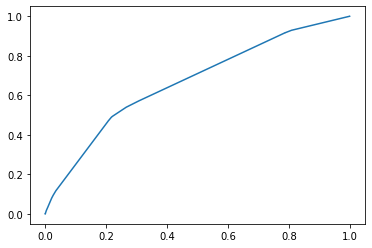

In [232]:
fpr, tpr, threshold = metrics.roc_curve(labels, preds)
plt.plot(fpr, tpr)

In [233]:
top_5 = []
for featureNum in m_DT_model.stages[-1].featureImportances.toArray().argsort():
    if m_DT_inputCols[featureNum] in top_5:
        continue
    top_5.append(m_DT_inputCols[featureNum])
    print("Process_DecisionTree feature NO.{} : {}".format(len(top_5), m_DT_inputCols[featureNum]))
    if len(top_5) == 5:
        break

Process_DecisionTree feature NO.1 : RGROW
Process_DecisionTree feature NO.2 : MAJFLT
Process_DecisionTree feature NO.3 : VSIZE
Process_DecisionTree feature NO.4 : RSIZE
Process_DecisionTree feature NO.5 : VSTEXT


In [234]:
top_5 = []
for featureNum in m_GBT_model.stages[-1].featureImportances.toArray().argsort():
    if m_GBT_inputCols[featureNum] in top_5:
        continue
    top_5.append(m_GBT_inputCols[featureNum])
    print("Process_DecisionTree feature NO.{} : {}".format(len(top_5), m_GBT_inputCols[featureNum]))
    if len(top_5) == 5:
        break

Process_DecisionTree feature NO.1 : MAJFLT
Process_DecisionTree feature NO.2 : RGROW
Process_DecisionTree feature NO.3 : MINFLT
Process_DecisionTree feature NO.4 : VSIZE
Process_DecisionTree feature NO.5 : VSTEXT


In [235]:
import sklearn.metrics as metrics
preds = m_GBT_prediction.select("probability").rdd.map(lambda x: x[0][1]).collect()
labels = m_GBT_prediction.select("attack").rdd.map(lambda x : x[0]).collect()

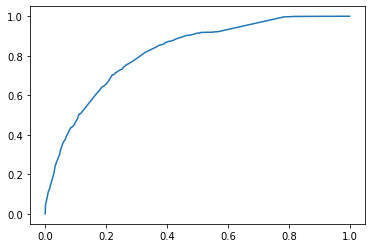

In [240]:
fpr, tpr, threshold = metrics.roc_curve(labels, preds)
plt.plot(fpr, tpr)

### 5. Using the pipeline model you selected in the previous step, re-train the pipeline model using a bigger set of rebalanced training data, with attack events and non-attack events being 1:2 ratio, while using all attack events data from the full data for both use cases. Then persist the better models for each use case.

#### process activity

In [241]:
train_process = process_df
# using all attack events data from the full data
train_process_attack = train_process.filter(F.col('attack') == 1)
train_process_normal = train_process.filter(F.col('attack') == 0)
# attack events and non-attack events being 1:2 ratio
train_process_normal = train_process_normal.sample(train_process_attack.count() * 2 / train_process_normal.count())
train_process = train_process_normal.union(train_process_attack).cache()

In [242]:
cols = ['POLI','NICE','PRI','Status','EXC','State','attack']

In [243]:
process_train_df = train_process.select(cols)
test_process = test_process.select(cols)

In [244]:
# First convert POLI according to our custom Transformer dict
key = ["norm", "btch", "idle", "fifo", "rr", "0", "-"]
value = ['0', '1', '2', '3', '4', '5', '6']
dic = {k:v for (k,v) in zip(key,value)}
process_train_df = process_train_df.na.replace(dic,1,"POLI")
process_train_df = process_train_df.withColumn("POLI", F.col("POLI").cast(IntegerType()))
test_process = test_process.na.replace(dic,1,"POLI")
test_process = test_process.withColumn("POLI", F.col("POLI").cast(IntegerType()))

/home/student/.local/lib/python3.8/site-packages/pyspark/sql/dataframe.py:1894: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


In [245]:
p_GBT_model = p_GBT_pipeline.fit(process_train_df)

In [246]:
# import  os
# cwd = os.getcwd()
p_GBT_model.write().overwrite().save('process_GBT_prediction_model')

#### memory activity

In [247]:
train_memory =  memory_df
train_memory_attack = train_memory.filter(F.col('attack') == 1)
train_memory_normal = train_memory.filter(F.col('attack') == 0)
train_memory_normal = train_memory_normal.sample(train_memory_attack.count() * 2 / train_memory_normal.count())
train_memory = train_memory_normal.union(train_memory_attack).cache()

In [248]:
cols = ['MINFLT','MAJFLT','VSTEXT', 'VSIZE', 'RSIZE', 'RGROW','attack']

In [249]:
memory_train_df = train_memory.select(cols)
test_memory = test_memory.select(cols)

In [250]:
m_GBT_model = m_GBT_pipeline.fit(memory_train_df)

In [251]:
# import  os
# cwd = os.getcwd()
m_GBT_model.write().overwrite().save('memory_GBT_prediction_model')

# 3. Knowledge sharing
## 3.1 How many jobs are observed when training the KMeans clustering model following the code below?

In [252]:
from pyspark.ml.clustering import KMeans
iris_df = spark.createDataFrame([ 
    (4.7, 3.2, 1.3, 0.2), 
    (4.9, 3.1, 1.5, 0.1), 
    (5.4, 3.9, 1.3, 0.4), 
    (5.0, 3.4, 1.6, 0.4), 
    (5.1, 3.8, 1.6, 0.2), 
    (4.9, 2.4, 3.3, 1.0), 
    (6.6, 2.9, 4.6, 1.3), 
    (5.6, 3.0, 4.5, 1.5), 
    (5.7, 2.6, 3.5, 1.0), 
    (5.8, 2.6, 4.0, 1.2), 
    (5.8, 2.8, 5.1, 2.4), 
    (6.2, 2.8, 4.8, 1.8), 
    (6.0, 3.0, 4.8, 1.8), 
    (6.7, 3.1, 5.6, 2.4), 
    (6.7, 3.0, 5.2, 2.3), 
    (6.2, 3.4, 5.4, 2.3)], 
    ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']) 
assembler = VectorAssembler( 
    inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], 
    outputCol='features') 
kmeans = KMeans(k=3).fit(assembler.transform(iris_df))

In [253]:
spark

As you can see from the screenshot there are nine jobs：

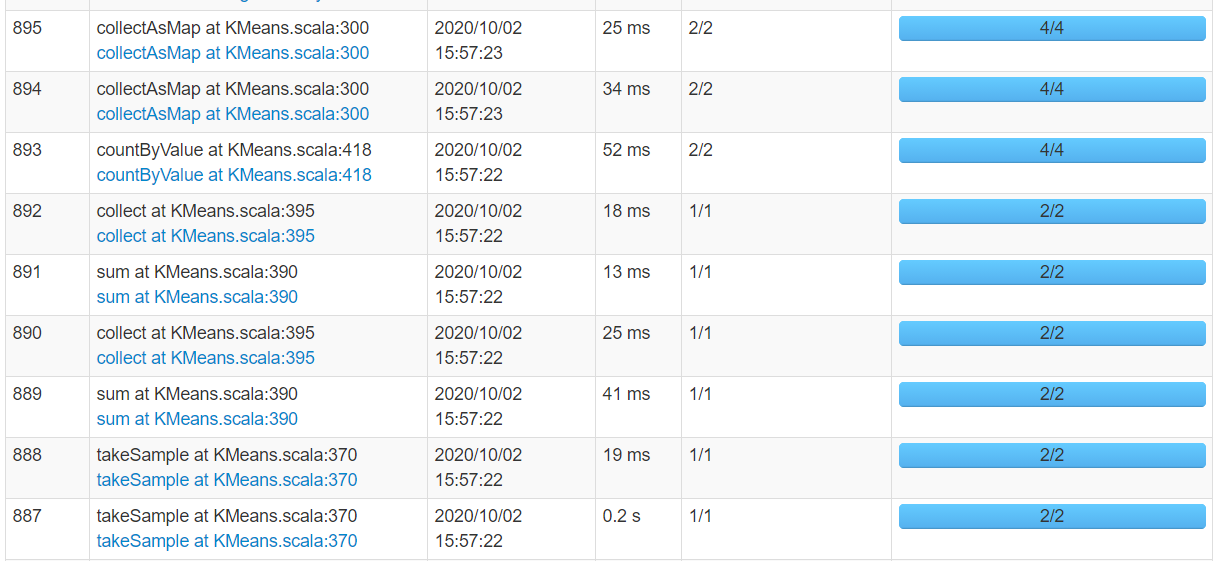

## 3.2 Combining the KMeans algorithm from the lecture, explain what each job in Spark UI represents 

### takeSample at KMeans：
             Spark has a method called initKMeansParallel to generate the initial center, where localkmeans class is mainly used to implement KMeans++ methods to get the center. Runs a KMeans task and chooses the smallest cost as the most appropriate clustering result. So this initKMeansParallel method also returns an Array[Array[VectorWithNorm]]. It's a two-dimensional array that represents a group of centroids with runs and k vectors per group centroid.
          
### sum at KMeans：
          //Loop and iterate through the known center points to find the other center points.
           while (step < initializationSteps) {
              val bcNewCenters = data.context.broadcast(newCenters)
              bcNewCentersList += bcNewCenters
              val preCosts = costs
              // Cost of distance of each point from the nearest centre
              costs = data.zip(preCosts).map { case (point, cost) =>
 ### collect at KMeans：
              //pointCost gets the distance to the nearest center point.
              // and take the smaller one compared to the distance of the previous iteration
                math.min(distanceMeasureInstance.pointCost(bcNewCenters.value, point), cost)
              }.persist(StorageLevel.MEMORY_AND_DISK)
              val chosen = data.zip(costs).mapPartitionsWithIndex { (index, pointCosts) =>
              // Select the points that satisfy the probability condition
                val rand = new XORShiftRandom(seed ^ (step << 16) ^ index)
               //sumCosts represents the total cost value under each runs parameter that was previously aggregated by aggregate.
                pointCosts.filter { case (_, c) => rand.nextDouble() < 2.0 * c * k / sumCosts }.map(_._1)
              }.collect()
          newCenters = chosen.map(_.toDense)
          centers ++= newCenters
          step += 1
          }

### countByValue at KMeans：
          // Finally, we may have a set of more than k different candidate centers
          val bcCenters = data.context.broadcast(distinctCenters)
          val countMap = data
            .map(distanceMeasureInstance.findClosest(bcCenters.value, _)._1)
            .countByValue()

          bcCenters.destroy()
          // weight each candidate center according to the number of points mapped to it in the dataset
          val myWeights = distinctCenters.indices.map(countMap.getOrElse(_, 0L).toDouble).toArray
          // run a local k-means++ on the weighted centers to select the k of them.
          LocalKMeans.kMeansPlusPlus(0, distinctCenters, myWeights, k, 30)
### collectAsMap at KMeans：
           // Find the nearest cluster center by the current cluster center.
          // findClosest is for calculating bestDistance.
          val (bestCenter, cost) = distanceMeasureInstance.findClosest(centers, stats, point)
          // doubleAccumulator
          costAccum.add(cost * point.weight)
          //sums represents the center point sample summation value.
          distanceMeasureInstance.updateClusterSum(point, sums(bestCenter))
          clusterWeightSum(bestCenter) += point.weight